# 사용할 모듈 불러오기

In [1]:
# 사용할 모듈 불러오기 
# 라벨인코딩
from sklearn.preprocessing import LabelEncoder
# 그래프
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
# 기본
import numpy as np
import pandas as pd
import seaborn as sns
# 함수 사용시 사용
import re
# itertools의 product은 리스트 간의 데카르트 곱을  구하는 데 사용된다.
from itertools import product




In [2]:
# 데이터 불러오기
items = pd.read_csv("./data/items.csv")
shops = pd.read_csv("./data/shops.csv")
train = pd.read_csv("./data/sales_train.csv")
test = pd.read_csv("./data/test.csv")
item_categories = pd.read_csv('./data/item_categories.csv')
submission = pd.read_csv("./data/sample_submission.csv")

In [3]:
font_path = "C:/Windows/Fonts/NanumGothic.otf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%matplotlib inline

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Windows\\Fonts\\NanumGothic.otf'

# EDA

### 데이터 크기에 맞게 메모리 줄이기

In [3]:
def reduce_mem_usage(df, show_result=True):
    num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    # 총 메모리를 Mb단위로 표현해준다. 
    start_mem = df.memory_usage().sum() / 1024**2
    # 각 열별로 데이터 타입 및 최대 최소 값 확인 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in num_types:
            c_min = df[col].min()
            c_max = df[col].max()
            # 만약 정수형이라면 
            if str(col_type)[:3] == 'int':
                # np.iinfo()해당 형이 표현 가능한 최댓값 최솟값을 출력해준다. 
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            # 만약 실수형이라면
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if show_result: 
        print('Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)'
              .format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## shops

In [4]:
shops.info() # 결측값은 없고 데이터 타입이 적당함을 알수있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [5]:
shops.head(10)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


- 이름에 특수문자가 들어가고 중복되는 이름들이 보인다

In [6]:
def clean_text(inputString):
    text_rmv = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', ' ', inputString)
    return text_rmv
shops_names = shops["shop_name"].apply(clean_text)
shops_id = shops["shop_id"]
# 중복되는 이름 확인 
for i in list(zip(shops_names ,shops_id)):
    for j in list(zip(shops_names ,shops_id)):
        if (re.match('.*'+i[0]+'*.',j[0])) and (i[1]!= j[1]):
            print('code : ', i[1], ' and  ', j[1])
            print('name : ', i[0], ' and  ', j[0])
            

code :  10  and   11
name :  Жуковский ул  Чкалова 39м   and   Жуковский ул  Чкалова 39м²
code :  11  and   10
name :  Жуковский ул  Чкалова 39м²  and   Жуковский ул  Чкалова 39м 
code :  39  and   40
name :  РостовНаДону ТРК  Мегацентр Горизонт   and   РостовНаДону ТРК  Мегацентр Горизонт  Островной
code :  57  and   0
name :  Якутск Орджоникидзе  56  and    Якутск Орджоникидзе  56 фран
code :  58  and   1
name :  Якутск ТЦ  Центральный   and    Якутск ТЦ  Центральный  фран


- 위와 같이 shop id가 10:11, 39:40, 57:0, 58:1 4개의 아이디가 중복되는 것을 알 수 있다.
- 위의 데이터를 기준으로 train data의 shop id를 바꾸어준다

In [7]:
train["shop_id"] = train["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})

##  test , submission

In [8]:
test.info()  # 결측값은 없고 데이터 타입이 적당함을 알수있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [9]:
submission.info() # item_cnt_day 가 아니라 item_cnt_month가 필요함을 알수가있다. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              214200 non-null  int64  
 1   item_cnt_month  214200 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 3.3 MB


In [10]:
# test의 shop_id , item_id 기 train 데이터에 있는지 확인
diff_train_test_shop_id  = set(train['shop_id']) - set(test['shop_id'])
print('diffrent shop_id nums: ',len(diff_train_test_shop_id))
diff_test_train_item_id = set(test['item_id']) - set(train['item_id'])
print('diffrent item_id nums: ',len(diff_test_train_item_id))
diff_test_items_item_id = set(test['item_id']) - set(items['item_id'])
print('diff_test_items_itemid nums: ',len(diff_test_items_item_id))

diffrent shop_id nums:  14
diffrent item_id nums:  363
diff_test_items_itemid nums:  0


## 아하!
- test에 시간 데이터가 존재하지 않으므로 date_block_num =34 를 추가한다.
- shop_id,item_id,date_block_num을 기준으로 묶어 item_cnt_day -> item_cnt_month 로 변환한다. 
- test에는 존재하지만 train에 존재하지 않는 값이 363개 존재한다. 
- train에만 있는 가게가 14개 존재한다. 

## Train

In [11]:
train.info() # null 값이 모든데이터에 존재 하지 않는다. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [12]:
#  date의 자료형을 object  -> dattime 으로 바꾸고 싶다. 
# 변환하는 과정  ->
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")
train["date"]. head(3) 

0   2013-01-02
1   2013-01-03
2   2013-01-05
Name: date, dtype: datetime64[ns]

In [13]:
train.describe(include = 'all')

<ipython-input-13-90378c3909a9>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  train.describe(include = 'all')


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
unique,1034,NaN,NaN,NaN,NaN,NaN
top,2013-12-28 00:00:00,NaN,NaN,NaN,NaN,NaN
freq,9434,NaN,NaN,NaN,NaN,NaN
first,2013-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
last,2015-10-31 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.456991e+01,3.330172e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,NaN,9.422988e+00,1.614678e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,NaN,0.000000e+00,2.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,NaN,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00


2013-01-01 00:00:00 ~ 2015-10-31 00:00:00  까지의 1034일간의 데이터임을 알수있다.  
item_price은 평균과 중위값의 차이가 심한 것으로 보아 이상치가 존재함을 알 수 있디.  
item_cnt_day 는일,이,삼 분위수가 1인데 비해 평균은 대략 1.2  최대값은 2168로 이상치가 존재한다.   
item_cnt_day, item_price에 최소값들은 음수이다.  

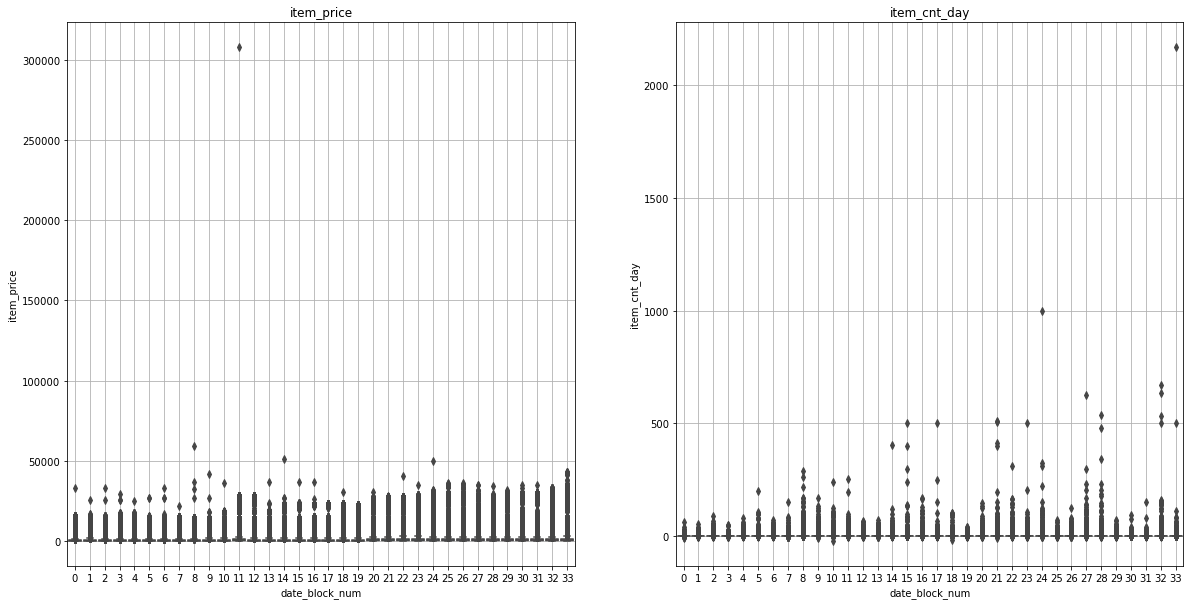

In [14]:
def price_item_cnt_day_boxplot():
    plt.figure(figsize = (20,10))
    # item_price 의 박스플롯
    plt.subplot(1,2,1)
    sns.boxplot(x = 'date_block_num' , y= 'item_price',data =train)
    plt.title('item_price')
    plt.grid()
    # item_cnt_day의 박스 플롯
    plt.subplot(1,2,2)
    sns.boxplot(x = 'date_block_num' , y= 'item_cnt_day',data =train)
    plt.title('item_cnt_day')
    plt.grid()
price_item_cnt_day_boxplot()

- 다음은 date_block_num 별로 item_price의 boxplot이다.  
- 위의 그래프를 기준으로 item_price는 50000 이상 , item_cnt_day 는 1000 이상을 이상치로서 train에서 제거한다.  
- 또한 판매되는 수량을 구하는 것이 목적이므로 0미만의 값을 제거한다.

In [15]:
condition_for_drop = ((train["item_price"] >= 50000) | (train["item_price"] < 0))
train.drop(train[condition_for_drop].index, axis = 0 , inplace=True)

condition_for_drop = ((train["item_cnt_day"] >= 1000) | (train["item_cnt_day"] < 0))
train.drop(train[condition_for_drop].index, axis = 0 , inplace=True)

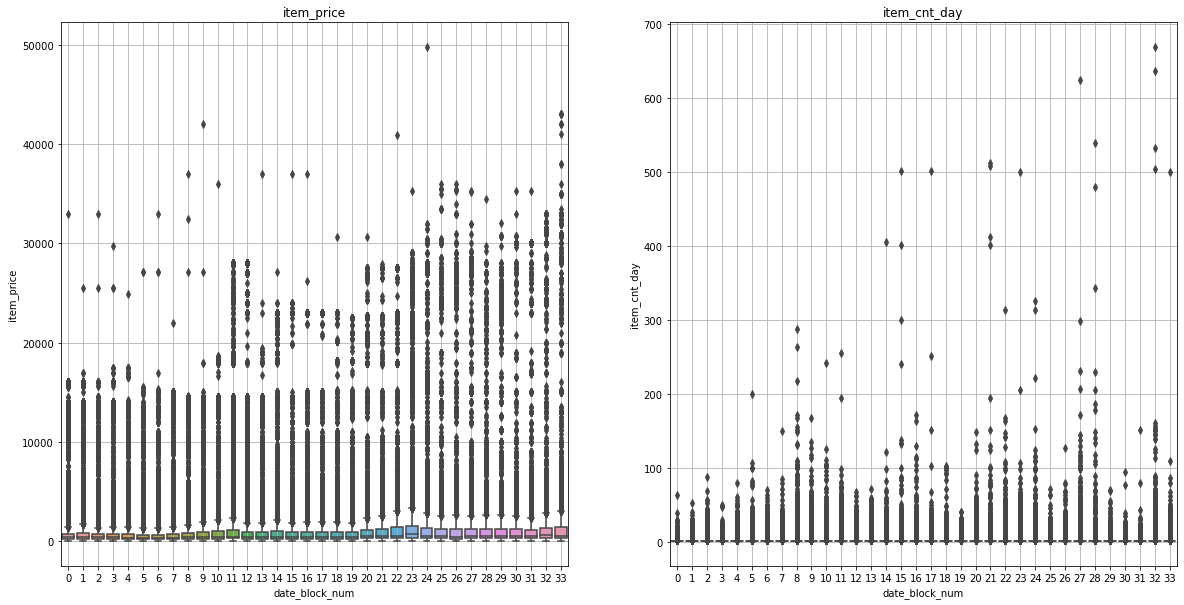

In [16]:
# 제거 후의 boxplot
price_item_cnt_day_boxplot()

### train 에만 존재하는 가게 지우기 

In [17]:
train = train[~train['shop_id'].isin(diff_train_test_shop_id)]

### test 모든 가게에 대해 파는 아이템 조합

In [18]:
'''
방법 1
itertools 의 product을 사용하여
각 달 아이템이 팔린 가게와 아이템 , data_num_block의 조합을 출력한다. 
'''

temp_train = []
for i in range(34):
    all_shops = train.loc[train['date_block_num'] == i , 'shop_id'].unique()
    all_items = train.loc[train['date_block_num'] == i , 'item_id'].unique()
    temp_train.append(np.array(list(product([i] , all_shops ,all_items))))
base_features_names = ['date_block_num','shop_id' , 'item_id']
# np.vstack 세로 결합 (열의 갯수가 같아야 한다.)
temp_train = pd.DataFrame(np.vstack(temp_train) , columns = base_features_names)

In [19]:
'''
doing
item_cnt_day >> item_cnt_month 
'''
train_item_cnt_month  = train.pivot_table(index = base_features_names ,
                                          values = 'item_cnt_day' , 
                                          aggfunc = np.sum)
temp_train = pd.merge(temp_train,train_item_cnt_month.reset_index(),on = base_features_names,how= 'left')

temp_train.rename(columns= {'item_cnt_day':'item_cnt_month'} ,inplace = True)

In [20]:
'''
doing
item_price  >> item_price_mean_month
adding
item_count
'''
train_item_cnt_month  = train.pivot_table(index = base_features_names ,
                                          values = ['item_cnt_day' , 'item_price'] , 
                                          aggfunc = {'item_cnt_day':'count' ,'item_price' :np.mean})
temp_train = pd.merge(temp_train,train_item_cnt_month.reset_index(),on = base_features_names,how= 'left')
temp_train.rename(columns= {'item_cnt_day':'item_count' ,'item_price' :'item_price_mean_month'} 
                  ,inplace = True)
temp_train.fillna(0 , inplace = True)
temp_train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_count,item_price_mean_month
0,0,59,22154,1.0,1.0,999.0
1,0,59,2552,0.0,0.0,0.0
2,0,59,2554,0.0,0.0,0.0
3,0,59,2555,0.0,0.0,0.0
4,0,59,2564,0.0,0.0,0.0


In [21]:
temp_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8642761 entries, 0 to 8642760
Data columns (total 6 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   date_block_num         int64  
 1   shop_id                int64  
 2   item_id                int64  
 3   item_cnt_month         float64
 4   item_count             float64
 5   item_price_mean_month  float64
dtypes: float64(3), int64(3)
memory usage: 461.6 MB


## items

In [22]:
items.info() # 결측값은 없고 데이터 타입이 적당함을 알수있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [23]:
items.head(20)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


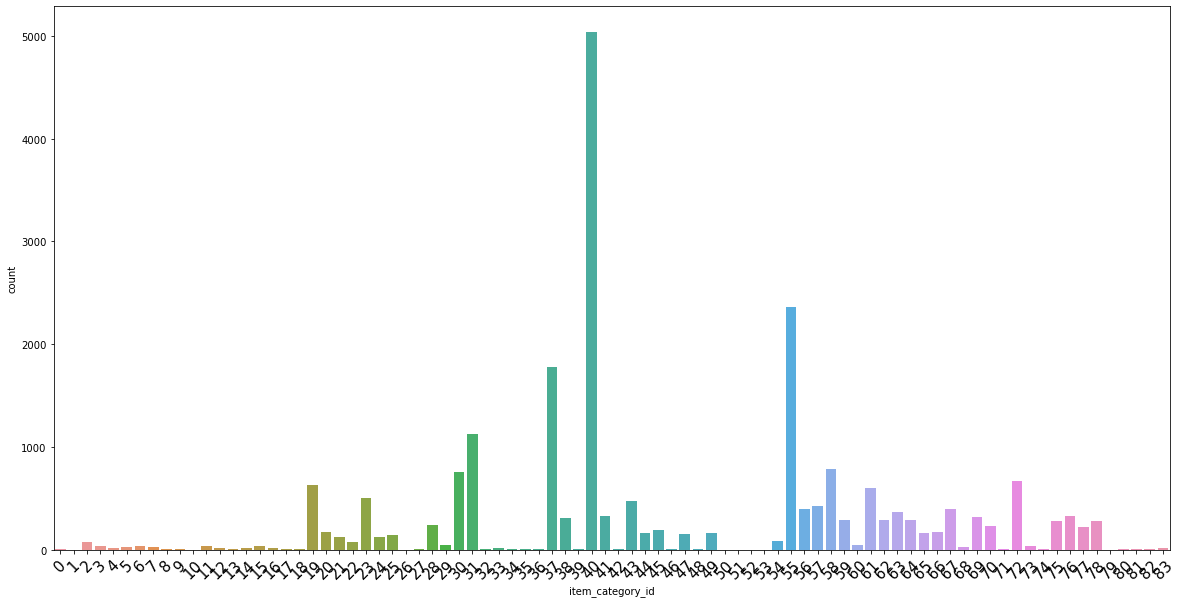

In [24]:
plt.figure(figsize=(20,10))
sns.countplot(x= 'item_category_id' , data = items)
plt.xticks(size = 15 , rotation =  45 , color = 'black')
plt.show()

In [25]:
item_categories[item_categories['item_category_id']==40]

,item_category_name,item_category_id
40,Кино - DVD,40


- 특정 카테고리에 아이템이 몰려 있는 것을 확인 할 수 있다. 
- 이를 해결하기 위해 상위 카테고리를 분리 후 데이터가 수가 작은 카테고리는 기타 카테고리에 묶는 작업이 필요하다.

## item_category

In [26]:
item_categories.info()  # 결측값은 없고 데이터 타입이 적당함을 알수있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [27]:
item_categories.head(20)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


- item_category_name에 같은 단어가 들어가는 데이터가 많이 존재한다
- 이를 묶어 더 큰 범주를 만들 수 있다.

## high_category

item_category의 앞부분만 자르고 새롭게 만든 열을 라벨인코딩 (악세사리 >> 1)   
item_id와 연결되어있는 item_category를 새롭게 만든 열로 연결하여 test값을 예측한다면?

In [28]:
# item_category 분류하여 새로운 열 만들기
def make_high_category(data_name_col):
    '''
    상위 분류를 생성후 라벨 인코딩을 하는 함수
    shopname 과 item_category_name 에 사용
    '''
    data_name_col
    data_name_col = data_name_col.apply(clean_text)
    high_category_name = data_name_col.str.split(' ')
    high_category_name = [data[1] if data[0] == '' else data[0] for data in high_category_name]
    high_category_name_le = LabelEncoder()
    high_category_name_le.fit(high_category_name)
    high_category_id = high_category_name_le.transform(high_category_name)
    return high_category_name , high_category_id

### 아이템 상위 카테고리 high_category_name

In [29]:
item_categories['high_category_name'] , item_categories['high_category_id'] =\
make_high_category(item_categories.item_category_name)

In [30]:
item_categories_value_counts=item_categories['high_category_name'].value_counts()
print(item_categories_value_counts)
item_categories_value_counts = item_categories_value_counts[item_categories['high_category_name'].value_counts()<5].index

Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Кино           5
Карты          5
Чистые         2
Служебные      2
Билеты         1
PC             1
Доставка       1
Элементы       1
Name: high_category_name, dtype: int64


In [31]:
# 아이템 종류가 5개 미만인 상위 카테고리는 etc로 묶어준다.

In [32]:
item_categories['high_category_name'] = \
item_categories['high_category_name'].apply(lambda x : 'etc' if x in item_categories_value_counts else x)

In [33]:
item_categories['high_category_name'].value_counts()

Игры          14
Книги         13
Подарки       12
Игровые        8
etc            8
Аксессуары     7
Музыка         6
Программы      6
Кино           5
Карты          5
Name: high_category_name, dtype: int64

### shop 상위 카테고리 city

In [34]:
shops['city_name'],shops['city_id'] = make_high_category(shops.shop_name)

In [35]:
shops.head(3)

,shop_name,shop_id,city_name,city_id
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0


## train + test 

In [36]:
'''
test에 없는 열을 추가 해야 하거나
train에 쓸모없는 데이터를 제거해야 한다. 
'''
test.columns , temp_train.columns

(Index(['ID', 'shop_id', 'item_id'], dtype='object'),
 Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_count',
        'item_price_mean_month'],
       dtype='object'))

In [37]:
test['date_block_num'] = 34

del test['ID']

In [38]:
test.columns , temp_train.columns

(Index(['shop_id', 'item_id', 'date_block_num'], dtype='object'),
 Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_count',
        'item_price_mean_month'],
       dtype='object'))

In [39]:
# 인덱스 값이 꼬여있다.
pd.concat([test,temp_train]).fillna(0)

,shop_id,item_id,date_block_num,item_cnt_month,item_count,item_price_mean_month
0,5,5037,34,0.0,0.0,0.0
1,5,5320,34,0.0,0.0,0.0
2,5,5233,34,0.0,0.0,0.0
3,5,5232,34,0.0,0.0,0.0
4,5,5268,34,0.0,0.0,0.0
...,...,...,...,...,...,...
8642756,21,7635,33,0.0,0.0,0.0
8642757,21,7638,33,0.0,0.0,0.0
8642758,21,7640,33,0.0,0.0,0.0
8642759,21,7632,33,0.0,0.0,0.0


In [40]:
pd.concat([test,temp_train]).fillna(0).sort_values('date_block_num').reset_index().drop('index',axis = 1)

,shop_id,item_id,date_block_num,item_cnt_month,item_count,item_price_mean_month
0,35,9613,0,0.0,0.0,0.0
1,7,9978,0,0.0,0.0,0.0
2,7,10055,0,0.0,0.0,0.0
3,7,11165,0,0.0,0.0,0.0
4,7,8075,0,0.0,0.0,0.0
...,...,...,...,...,...,...
8856956,57,16188,34,0.0,0.0,0.0
8856957,57,18454,34,0.0,0.0,0.0
8856958,57,18027,34,0.0,0.0,0.0
8856959,57,1041,34,0.0,0.0,0.0


In [41]:
sales_df = pd.concat([test,temp_train]).fillna(0).sort_values('date_block_num').reset_index().drop('index',axis = 1)

## merging item , city data

In [42]:
sales_df = pd.merge(sales_df ,shops ,on =  'shop_id').drop(['shop_name','city_name'] ,axis =1)

In [43]:
sales_df.head(3)

,shop_id,item_id,date_block_num,item_cnt_month,item_count,item_price_mean_month,city_id
0,35,9613,0,0.0,0.0,0.0,15
1,35,4148,0,0.0,0.0,0.0,15
2,35,4128,0,1.0,1.0,899.0,15


In [44]:
item_high_categories = items.merge(item_categories).drop(['item_name','item_category_name','high_category_name'],axis = 1)
item_high_categories.head(3)

,item_id,item_category_id,high_category_id
0,0,40,7
1,2,40,7
2,3,40,7


In [45]:
sales_df = pd.merge(sales_df ,item_high_categories ,on =  'item_id')

### add item_revenue_month

In [46]:
sales_df['item_revenue_month'] = sales_df.item_cnt_month * sales_df.item_price_mean_month

In [47]:
sales_df.head(3)

,shop_id,item_id,date_block_num,item_cnt_month,item_count,item_price_mean_month,city_id,item_category_id,high_category_id,item_revenue_month
0,35,9613,0,0.0,0.0,0.0,15,37,7,0.0
1,35,9613,1,0.0,0.0,0.0,15,37,7,0.0
2,35,9613,2,0.0,0.0,0.0,15,37,7,0.0


### add_month

In [48]:
sales_df['month'] = ((sales_df.date_block_num % 12) +1).astype(np.int8)

## 시각화

In [49]:
def draw_x_group_y_sum_barplot(x, y):
    temp_data_for_plot = \
    sales_df.pivot_table(index = x , values = y , aggfunc = np.sum).reset_index()
    plt.figure(figsize=(20,20))
    sns.barplot(x= x,
                y = y, 
                data = temp_data_for_plot)
    plt.title(f'{y}___per___{x}')
    plt.rc.fontsize = 20
    plt.show()

### date_block_num 별 팔린 횟수

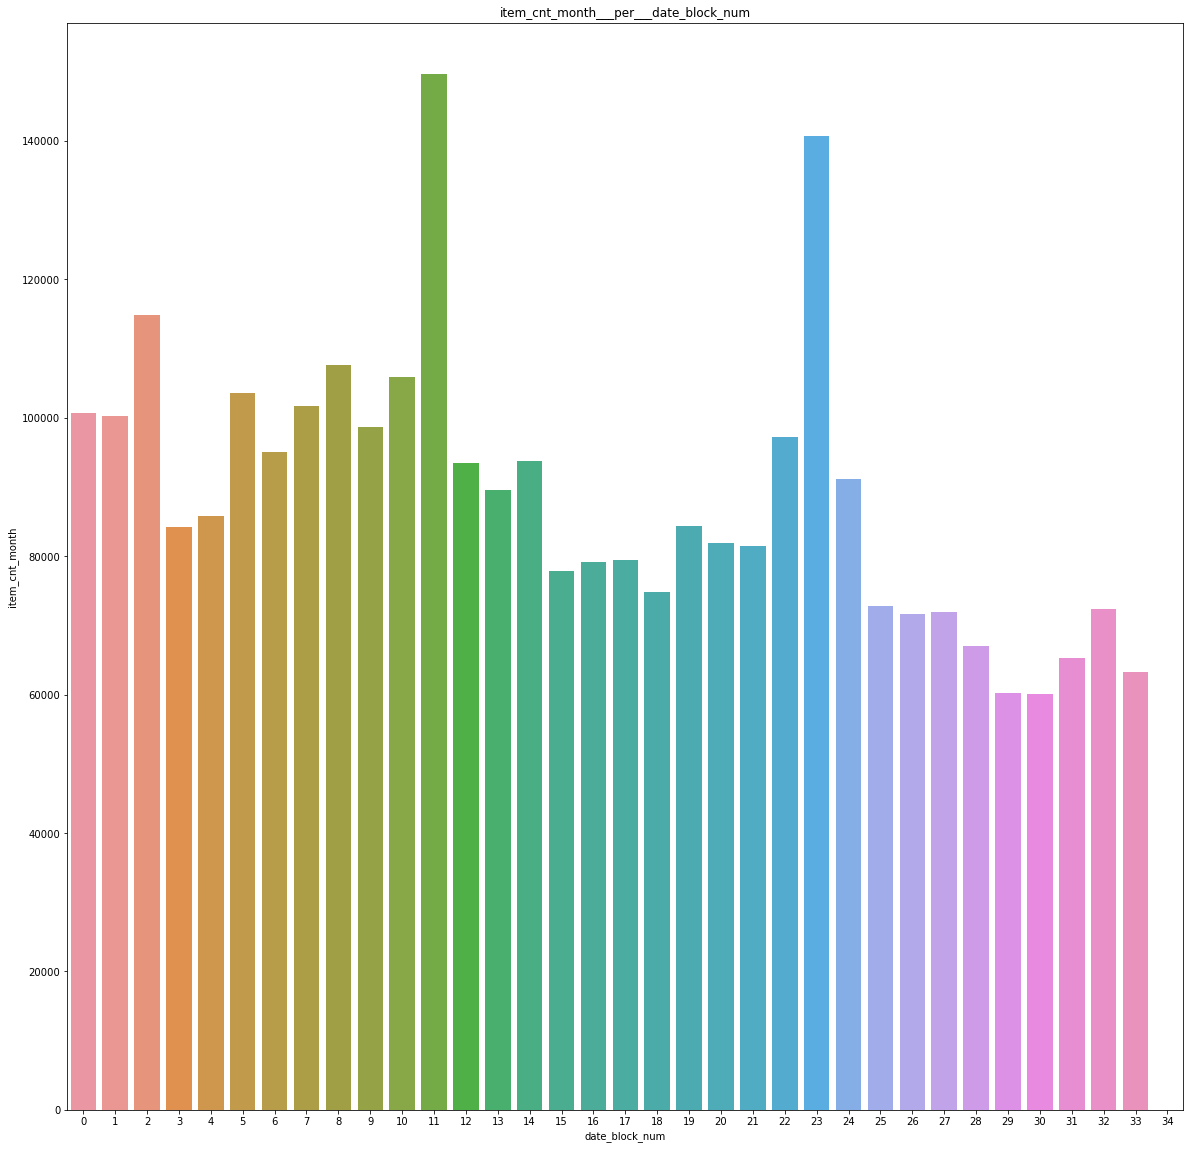

In [50]:
draw_x_group_y_sum_barplot('date_block_num','item_cnt_month')

### 달별 팔린 횟수 

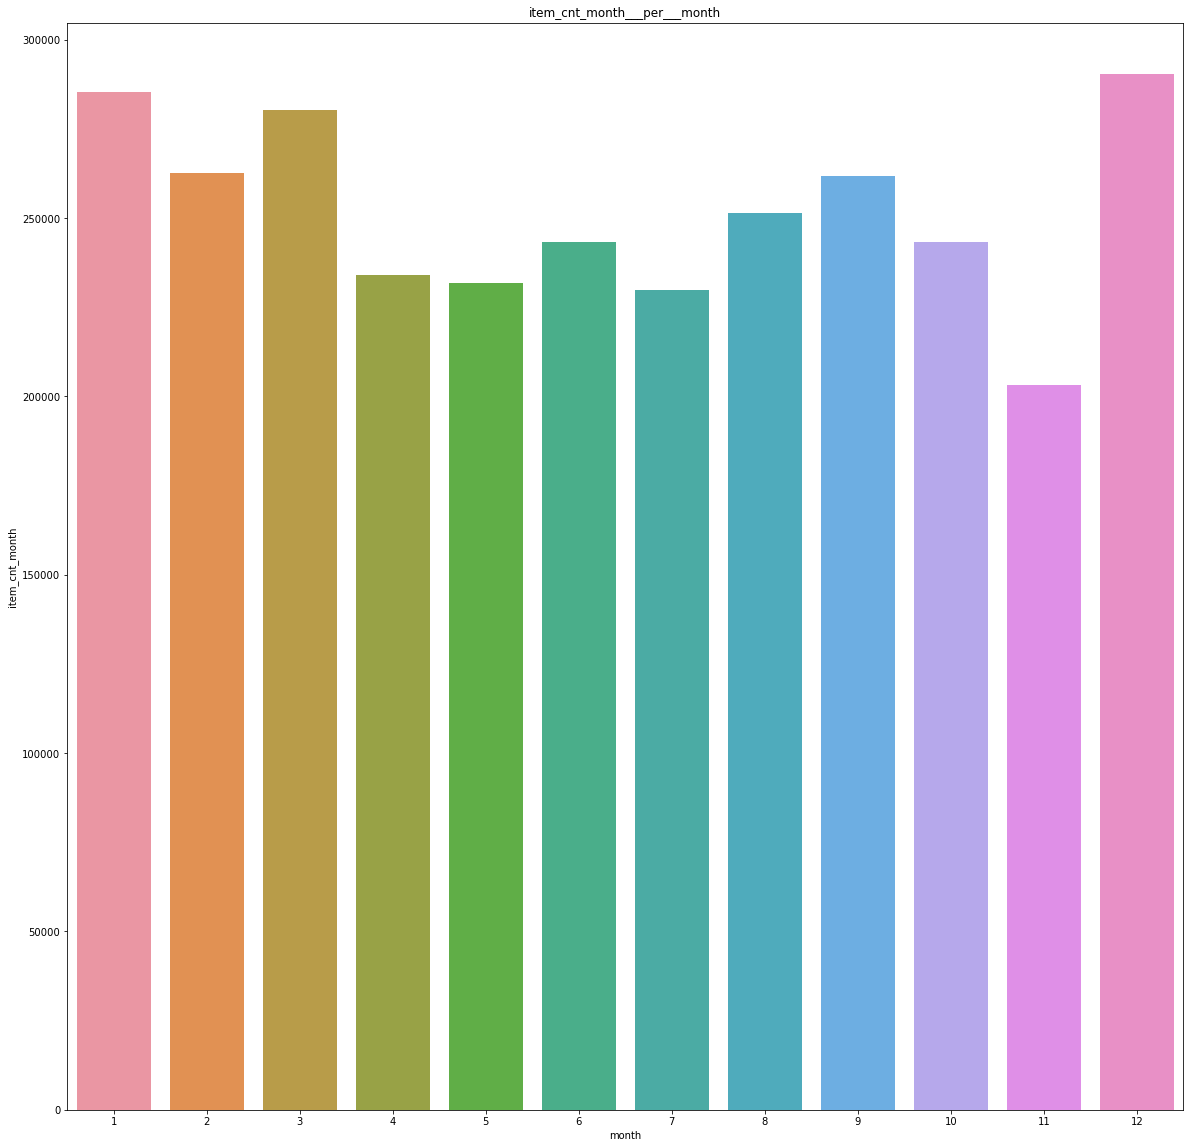

In [51]:
draw_x_group_y_sum_barplot('month','item_cnt_month')

In [52]:
def draw_x_group_y_sum_regplot(x, y):
    plt.figure(figsize=(20,20))
    sns.regplot(x= x,
                y = y, 
                data = sales_df)
    plt.title(f'{y}___per___{x}')
    plt.rc.fontsize = 20
    plt.show()

## add_mean_feature

In [53]:
def add_mean_feature(df , base_feature_names ,num_feature_names ,mean_feature_names ):
    '''
    base_feature_name를 기준으로 mean_feature_names의 값들을 
    한달 평균을 구해서 df에 병합해주는 함수
    '''
    df_pivot  = df[list(base_feature_names) + list(num_feature_names)]
    col_name_front = ''
    for base_feature_name in base_feature_names:
        if base_feature_name !='date_block_num':
            col_name_front += '_'.join(base_feature_name.split('_')[:-1])+'_'

    for num_feature_name in num_feature_names:
        col_name = col_name_front+num_feature_name.split('_')[1]+'_month_mean'
        df_pivot = df_pivot.rename(columns = {num_feature_name:col_name})
        print(f'{col_name}이 생성되었습니다.')
        mean_feature_names.append(col_name)

    df_pivot = df_pivot.pivot_table(index = base_feature_names)
    df = df.merge(df_pivot , on =base_feature_names)
    return df , mean_feature_names

In [54]:
base_feature_names = ['date_block_num','shop_id','item_id']
base_item_feature_names = ['item_id','item_category_id','high_category_id']
base_place_feature_names = ['shop_id','city_id']
catagory_feature_names = list(set(base_feature_names + base_item_feature_names + base_place_feature_names+["month"]))
# base_item_feature_names = ['high_category_id']
# base_place_feature_names = ['city_id']
num_feature_names = ['item_cnt_month','item_revenue_month','item_count']
mean_feature_names = []

In [55]:
for place in base_place_feature_names:
    for item in base_item_feature_names:
        base_feature_names = ['date_block_num', place,item]
        sales_df,mean_feature_names = add_mean_feature(sales_df ,base_feature_names,num_feature_names,mean_feature_names)

shop_item_cnt_month_mean이 생성되었습니다.
shop_item_revenue_month_mean이 생성되었습니다.
shop_item_count_month_mean이 생성되었습니다.
shop_item_category_cnt_month_mean이 생성되었습니다.
shop_item_category_revenue_month_mean이 생성되었습니다.
shop_item_category_count_month_mean이 생성되었습니다.
shop_high_category_cnt_month_mean이 생성되었습니다.
shop_high_category_revenue_month_mean이 생성되었습니다.
shop_high_category_count_month_mean이 생성되었습니다.
city_item_cnt_month_mean이 생성되었습니다.
city_item_revenue_month_mean이 생성되었습니다.
city_item_count_month_mean이 생성되었습니다.
city_item_category_cnt_month_mean이 생성되었습니다.
city_item_category_revenue_month_mean이 생성되었습니다.
city_item_category_count_month_mean이 생성되었습니다.
city_high_category_cnt_month_mean이 생성되었습니다.
city_high_category_revenue_month_mean이 생성되었습니다.
city_high_category_count_month_mean이 생성되었습니다.


In [56]:
sales_df.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'item_count',
       'item_price_mean_month', 'city_id', 'item_category_id',
       'high_category_id', 'item_revenue_month', 'month',
       'shop_item_cnt_month_mean', 'shop_item_count_month_mean',
       'shop_item_revenue_month_mean', 'shop_item_category_cnt_month_mean',
       'shop_item_category_count_month_mean',
       'shop_item_category_revenue_month_mean',
       'shop_high_category_cnt_month_mean',
       'shop_high_category_count_month_mean',
       'shop_high_category_revenue_month_mean', 'city_item_cnt_month_mean',
       'city_item_count_month_mean', 'city_item_revenue_month_mean',
       'city_item_category_cnt_month_mean',
       'city_item_category_count_month_mean',
       'city_item_category_revenue_month_mean',
       'city_high_category_cnt_month_mean',
       'city_high_category_count_month_mean',
       'city_high_category_revenue_month_mean'],
      dtype='object')

In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()    
scaler.fit(sales_df)
sales_df_scaled = scaler.transform(sales_df)
sales_df_scaled

array([[ 0.22401033, -0.26345542, -1.60547735, ..., -0.14683689,
        -0.39748587, -0.15002705],
       [ 0.22401033, -1.60513589, -1.60547735, ..., -0.14683689,
        -0.39748587, -0.15002705],
       [ 0.22401033, -1.63103644, -1.60547735, ..., -0.14683689,
        -0.39748587, -0.15002705],
       ...,
       [-1.44768825, -0.9346174 ,  1.80222033, ..., -0.30825228,
        -0.99727353, -0.18908992],
       [ 1.33847606, -0.9346174 ,  1.80222033, ..., -0.30825228,
        -0.99727353, -0.18908992],
       [ 0.94841305, -0.9346174 ,  1.80222033, ..., -0.30825228,
        -0.99727353, -0.18908992]])

In [63]:
from sklearn.decomposition import PCA

# 2차원으로 차원 축소, target 정보는 제외
pca = PCA(n_components = 29)
pca.fit(sales_df_scaled)
 
# pca transform 후 데이터프레임으로 자료형 변경
df_pca = pca.transform(sales_df_scaled)
df_pca = pd.DataFrame(df_pca, columns = ['component 0', 
                                         'component 1',
                                        'component 2',
                                        'component 3',
                                        'component 4'
                                        ,'component 5',
                                        'component 6',
                                        'component 7',
                                        'component 8',
                                        'component 9',
                                        'component 10',
                                        'component 11',
                                        'component 12',
                                        'component 13',
                                        'component 14',
                                        'component 15',
                                        'component 16',
                                        'component 17',
                                        'component 18',
                                        'component 19',
                                        'component 20',
                                        'component 21',
                                        'component 22',
                                        'component 23',
                                        'component 24',
                                        'component 25',
                                        'component 26',
                                        'component 27',
                                        'component 28'])

df_pca


,component 0,component 1,component 2,component 3,component 4,component 5,component 6,component 7,component 8,component 9,...,component 19,component 20,component 21,component 22,component 23,component 24,component 25,component 26,component 27,component 28
0,-0.721517,0.178432,0.075548,-0.187919,-0.090428,0.544689,0.640291,2.194210,0.399803,-0.165354,...,0.060226,-0.101969,-0.017296,0.060499,-0.156851,0.003001,0.008322,-2.873545e-16,3.700304e-16,1.842404e-16
1,-0.677769,0.159461,0.182045,-0.365531,-0.134125,0.597196,0.620459,2.071099,1.699906,-0.250419,...,0.073335,-0.121980,-0.016588,0.059837,-0.154441,0.002789,0.007466,-1.346988e-16,2.555386e-16,1.287293e-16
2,-0.676925,0.159095,0.184101,-0.368959,-0.134968,0.598210,0.620076,2.068723,1.725004,-0.252061,...,0.073588,-0.122366,-0.016575,0.059824,-0.154395,0.002785,0.007449,-1.346988e-16,2.520692e-16,1.217904e-16
3,-0.688391,0.164068,0.156187,-0.322406,-0.123515,0.584447,0.625274,2.100991,1.384233,-0.229765,...,0.070152,-0.117121,-0.016760,0.059998,-0.155027,0.002841,0.007674,-1.763322e-16,2.832942e-16,1.426071e-16
4,-0.787227,0.206928,-0.084416,0.078859,-0.024795,0.465821,0.670079,2.379126,-1.553002,-0.037584,...,0.040535,-0.071913,-0.018358,0.061492,-0.160470,0.003320,0.009607,-4.955213e-16,5.469722e-16,2.813850e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8856956,-0.660299,0.198663,0.924543,-2.450303,1.224657,4.076150,-3.115066,-0.765497,0.212353,0.058342,...,-0.360382,0.665980,-0.015286,-0.050647,0.156817,-0.006363,-0.021941,1.083704e-15,-1.063665e-16,-4.280934e-17
8856957,-0.655944,0.187773,0.936068,-2.483471,1.506192,4.105312,-3.132712,-0.740943,0.214978,0.052348,...,-0.360508,0.664504,-0.009092,-0.069119,0.203734,-0.007415,-0.024678,1.083704e-15,-1.063665e-16,-4.280934e-17
8856958,-0.722392,0.354478,0.760072,-1.974879,-2.815633,3.657001,-2.859695,-1.117927,0.174587,0.145658,...,-0.357485,0.664599,-0.027938,-0.012078,0.058510,-0.004280,-0.016548,1.083704e-15,-1.063665e-16,-7.056491e-17
8856959,-0.662194,0.203378,0.919537,-2.435971,1.103190,4.063591,-3.107532,-0.776089,0.211223,0.060879,...,-0.360368,0.667453,-0.020783,-0.034286,0.115279,-0.005428,-0.019506,1.083704e-15,-1.063665e-16,-4.280934e-17


In [64]:
print(pca.explained_variance_ratio_)

[3.07279145e-01 1.22711624e-01 1.11277265e-01 8.32293032e-02
 6.86623434e-02 5.35383740e-02 4.77803446e-02 4.26634561e-02
 3.29084512e-02 2.83164973e-02 2.49360555e-02 2.33722034e-02
 1.27731605e-02 1.15589489e-02 9.29382167e-03 5.59180952e-03
 4.32328186e-03 3.64192598e-03 2.58867914e-03 8.46644520e-04
 8.23387889e-04 7.09043728e-04 4.33900201e-04 3.83128085e-04
 1.86576363e-04 1.70629267e-04 1.70535872e-33 1.70535872e-33
 1.70535872e-33]


In [ ]:
import matplotlib.pyplot as plt

# class target 정보 불러오기 
df_pca['target'] = df_scaled['target']

# target 별 분리
df_pca_0 = df_pca[df_pca['target'] == 0]
df_pca_1 = df_pca[df_pca['target'] == 1]
df_pca_2 = df_pca[df_pca['target'] == 2]
df_pca_3 = df_pca[df_pca['target'] == 3]
df_pca_4 = df_pca[df_pca['target'] == 4]
df_pca_5 = df_pca[df_pca['target'] == 5]
df_pca_6 = df_pca[df_pca['target'] == 6]
df_pca_7 = df_pca[df_pca['target'] == 7]
df_pca_8 = df_pca[df_pca['target'] == 8]
df_pca_9 = df_pca[df_pca['target'] == 9]
df_pca_10 = df_pca[df_pca['target'] == 10]
df_pca_11 = df_pca[df_pca['target'] == 11]
df_pca_12 = df_pca[df_pca['target'] == 12]
df_pca_13 = df_pca[df_pca['target'] == 13]
df_pca_14 = df_pca[df_pca['target'] == 14]
df_pca_15 = df_pca[df_pca['target'] == 15]
df_pca_16 = df_pca[df_pca['target'] == 16]
df_pca_17 = df_pca[df_pca['target'] == 17]
df_pca_18 = df_pca[df_pca['target'] == 18]
df_pca_19 = df_pca[df_pca['target'] == 19]
df_pca_20 = df_pca[df_pca['target'] == 20]
df_pca_21 = df_pca[df_pca['target'] == 21]
df_pca_22 = df_pca[df_pca['target'] == 22]
df_pca_23 = df_pca[df_pca['target'] == 23]
df_pca_24 = df_pca[df_pca['target'] == 24]
df_pca_25 = df_pca[df_pca['target'] == 25]
df_pca_26 = df_pca[df_pca['target'] == 26]
df_pca_27 = df_pca[df_pca['target'] == 27]
df_pca_28 = df_pca[df_pca['target'] == 28]

# target 별 시각화
plt.scatter(df_pca_0['component 0'], df_pca_0['component 1'], color = 'orange', alpha = 0.7, label = 'setosa')
plt.scatter(df_pca_1['component 0'], df_pca_1['component 1'], color = 'red', alpha = 0.7, label = 'versicolor')
plt.scatter(df_pca_2['component 0'], df_pca_2['component 1'], color = 'green', alpha = 0.7, label = 'virginica')

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()

In [ ]:
sales_corr = sales_df.drop(columns = catagory_feature_names).corr() 
plt.figure(figsize=(20,20))
sns.heatmap(sales_corr, annot=True)
plt.show()

In [184]:
def find_high_corr_location(df_corr , threshold = 0.9):
    cols = df_corr.columns
    high_corr_location = []
    for col in cols :
        for index in cols:
            df_corr_data = [index,col,df_corr.loc[index,col]]
            df_corr_data_2 = [col,index,df_corr.loc[col,index]]
            if (df_corr_data[2] >threshold ) &  (index != col) &(df_corr_data_2 not in high_corr_location):
                high_corr_location.append(df_corr_data)
                print(f'{df_corr_data[0]}와{df_corr_data[1]}는 {df_corr_data[2]}의 상관계수를 가집니다.\n')
    return high_corr_location
        

In [185]:
find_high_corr_location(sales_df.drop(columns = catagory_feature_names).corr() ,0.9)

shop_item_cnt_month_mean와item_cnt_month는 1.0의 상관계수를 가집니다.

city_item_cnt_month_mean와item_cnt_month는 0.9024253892761113의 상관계수를 가집니다.

shop_item_count_month_mean와item_count는 1.0의 상관계수를 가집니다.

shop_item_revenue_month_mean와item_revenue_month는 1.0의 상관계수를 가집니다.

city_item_revenue_month_mean와item_revenue_month는 0.9512200737744495의 상관계수를 가집니다.

city_item_cnt_month_mean와shop_item_cnt_month_mean는 0.9024253892761113의 상관계수를 가집니다.

city_item_revenue_month_mean와shop_item_revenue_month_mean는 0.9512200737744495의 상관계수를 가집니다.

city_item_category_count_month_mean와shop_item_category_count_month_mean는 0.9184730708054436의 상관계수를 가집니다.

city_item_category_revenue_month_mean와shop_item_category_revenue_month_mean는 0.9628540405576748의 상관계수를 가집니다.

city_high_category_cnt_month_mean와shop_high_category_cnt_month_mean는 0.9703483548269765의 상관계수를 가집니다.

city_high_category_revenue_month_mean와shop_high_category_revenue_month_mean는 0.9720488959921785의 상관계수를 가집니다.



[['shop_item_cnt_month_mean', 'item_cnt_month', 1.0],
 ['city_item_cnt_month_mean', 'item_cnt_month', 0.9024253892761113],
 ['shop_item_count_month_mean', 'item_count', 1.0],
 ['shop_item_revenue_month_mean', 'item_revenue_month', 1.0],
 ['city_item_revenue_month_mean', 'item_revenue_month', 0.9512200737744495],
 ['city_item_cnt_month_mean', 'shop_item_cnt_month_mean', 0.9024253892761113],
 ['city_item_revenue_month_mean',
  'shop_item_revenue_month_mean',
  0.9512200737744495],
 ['city_item_category_count_month_mean',
  'shop_item_category_count_month_mean',
  0.9184730708054436],
 ['city_item_category_revenue_month_mean',
  'shop_item_category_revenue_month_mean',
  0.9628540405576748],
 ['city_high_category_cnt_month_mean',
  'shop_high_category_cnt_month_mean',
  0.9703483548269765],
 ['city_high_category_revenue_month_mean',
  'shop_high_category_revenue_month_mean',
  0.9720488959921785]]

In [186]:
drop_names =\
['shop_item_cnt_month_mean',
 'shop_item_count_month_mean',
 'shop_item_revenue_month_mean',
 'shop_item_category_count_month_mean',
 'shop_item_category_revenue_month_mean',
 'shop_high_category_cnt_month_mean',
 'shop_high_category_revenue_month_mean',
'city_item_cnt_month_mean',
'city_item_revenue_month_mean']
sales_df.drop(columns = drop_names ,axis =1)
mean_feature_names = list(set(mean_feature_names) - set(drop_names))

In [187]:
sales_df = sales_df.drop(columns = drop_names)

In [188]:
sales_df  =reduce_mem_usage(sales_df)

Mem. usage decreased to 405.44 Mb (68.6% reduction)


In [189]:
sales_df.dtypes

shop_id                                     int8
item_id                                    int16
date_block_num                              int8
item_cnt_month                           float16
item_count                               float16
item_price_mean_month                    float16
city_id                                     int8
item_category_id                            int8
high_category_id                            int8
item_revenue_month                       float32
month                                       int8
shop_item_category_cnt_month_mean        float16
shop_high_category_count_month_mean      float16
city_item_count_month_mean               float16
city_item_category_cnt_month_mean        float16
city_item_category_count_month_mean      float16
city_item_category_revenue_month_mean    float32
city_high_category_cnt_month_mean        float16
city_high_category_count_month_mean      float16
city_high_category_revenue_month_mean    float32
dtype: object

In [190]:
sales_df.T

,0,1,2,3,4,5,6,7,8,9,...,8856951,8856952,8856953,8856954,8856955,8856956,8856957,8856958,8856959,8856960
shop_id,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,...,36.0,12.0,47.0,50.0,49.0,56.0,59.0,5.0,55.0,48.0
item_id,9613.000000,1273.000000,1112.000000,3298.000000,22140.000000,21395.000000,11232.000000,11176.000000,16451.000000,20230.000000,...,5441.0,5441.0,5441.0,5441.0,5441.0,5441.0,5441.0,5441.0,5441.0,5441.0
date_block_num,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0
item_cnt_month,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
item_count,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
item_price_mean_month,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,499.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
city_id,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,...,16.0,7.0,22.0,24.0,24.0,28.0,30.0,3.0,27.0,23.0
item_category_id,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
high_category_id,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
item_revenue_month,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2495.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# add_lag_data

In [191]:
mean_feature_names

['city_item_category_count_month_mean',
 'city_high_category_count_month_mean',
 'city_item_category_revenue_month_mean',
 'city_high_category_cnt_month_mean',
 'shop_high_category_count_month_mean',
 'city_item_count_month_mean',
 'city_high_category_revenue_month_mean',
 'city_item_category_cnt_month_mean',
 'shop_item_category_cnt_month_mean']

In [192]:
def add_lag_data(df , base_feature_names, lag_feature,lag_feature_names, lag_period=3):
    df_temp = df.loc[:, base_feature_names + [lag_feature]].copy()
    for i in range(1,lag_period+1):
        col_name  = lag_feature +"_lag_"+f'{i}'
        lag_feature_names.append(col_name)
        df_temp['date_block_num'] +=i
        df_temp.columns = base_feature_names +[col_name]
        df_temp = df.loc[:,base_features_names].merge(df_temp.drop_duplicates(), 
                      on=base_feature_names, 
                      how='left')
        df_temp = df_temp.set_index(base_feature_names)
        df = df.set_index(base_feature_names)
        df[lag_feature].fillna(0)
        print(f'{col_name}을 생성하였습니다.')
    return df ,lag_feature_names
        
    

In [193]:
lag_feature_names = []
for lag_feature in (mean_feature_names + num_feature_names):
    sales_df,lag_feature_names = add_lag_data(sales_df,base_feature_names,lag_feature,lag_feature_names)

city_item_category_count_month_mean_lag_1을 생성하였습니다.


MemoryError: Unable to allocate 7.55 GiB for an array with shape (11, 368307089) and data type float16

In [85]:
sales_df.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'item_count',
       'item_price_mean_month', 'city_id', 'item_category_id',
       'high_category_id', 'item_revenue_month', 'month',
       'shop_item_category_cnt_month_mean',
       'shop_high_category_count_month_mean', 'city_item_cnt_month_mean',
       'city_item_count_month_mean', 'city_item_revenue_month_mean',
       'city_item_category_cnt_month_mean',
       'city_item_category_count_month_mean',
       'city_item_category_revenue_month_mean',
       'city_high_category_cnt_month_mean',
       'city_high_category_count_month_mean',
       'city_high_category_revenue_month_mean'],
      dtype='object')

# Holdsout

In [67]:
sales_df = reduce_mem_usage(sales_df)
x_train = sales_df[sales_df['date_block_num'] < 33]
x_train = x_train.drop(['item_cnt_month'], axis = 1)
y_train = sales_df[sales_df['date_block_num'] < 33]['item_cnt_month']


x_valid = sales_df[sales_df['date_block_num'] == 33]
x_valid = x_valid.drop(['item_cnt_month'], axis = 1)
y_valid = sales_df[sales_df['date_block_num'] == 33]['item_cnt_month']

x_test = sales_df[sales_df['date_block_num'] == 34]
x_test = x_test.drop(['item_cnt_month'], axis = 1)
y_test = sales_df[sales_df['date_block_num'] == 34]['item_cnt_month']

Mem. usage decreased to 405.44 Mb (0.0% reduction)


# XGboost

In [105]:
from xgboost import XGBRegressor
from xgboost import plot_importance

In [106]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    x_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set= [(x_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds = 150)

C:\Users\AW17R4\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\AW17R4\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:2.54621
[1]	validation_0-rmse:2.36864
[2]	validation_0-rmse:2.23757
[3]	validation_0-rmse:2.13704
[4]	validation_0-rmse:2.08490
[5]	validation_0-rmse:2.03264
[6]	validation_0-rmse:2.02294
[7]	validation_0-rmse:2.00528
[8]	validation_0-rmse:2.00529
[9]	validation_0-rmse:1.99106
[10]	validation_0-rmse:1.97657
[11]	validation_0-rmse:1.98121
[12]	validation_0-rmse:1.96838
[13]	validation_0-rmse:1.97652
[14]	validation_0-rmse:1.98318
[15]	validation_0-rmse:1.96382
[16]	validation_0-rmse:1.95935
[17]	validation_0-rmse:1.95018
[18]	validation_0-rmse:1.95968
[19]	validation_0-rmse:1.94884
[20]	validation_0-rmse:1.96025
[21]	validation_0-rmse:1.94794
[22]	validation_0-rmse:1.94304
[23]	validation_0-rmse:1.93839
[24]	validation_0-rmse:1.94825
[25]	validation_0-rmse:1.94591
[26]	validation_0-rmse:1.95687
[27]	validation_0-rmse:1.94886
[28]	validation_0-rmse:1.93930
[29]	validation_0-rmse:1.93418
[30]	validation_0-rmse:1.94043
[31]	validation_0-rmse:1.92864
[32]	validation_0-

[260]	validation_0-rmse:1.78808
[261]	validation_0-rmse:1.78564
[262]	validation_0-rmse:1.78319
[263]	validation_0-rmse:1.78523
[264]	validation_0-rmse:1.78353
[265]	validation_0-rmse:1.77373
[266]	validation_0-rmse:1.77050
[267]	validation_0-rmse:1.76993
[268]	validation_0-rmse:1.77364
[269]	validation_0-rmse:1.77475
[270]	validation_0-rmse:1.77450
[271]	validation_0-rmse:1.77486
[272]	validation_0-rmse:1.77511
[273]	validation_0-rmse:1.77658
[274]	validation_0-rmse:1.77654
[275]	validation_0-rmse:1.77889
[276]	validation_0-rmse:1.77931
[277]	validation_0-rmse:1.77865
[278]	validation_0-rmse:1.77789
[279]	validation_0-rmse:1.77942
[280]	validation_0-rmse:1.78274
[281]	validation_0-rmse:1.77895
[282]	validation_0-rmse:1.78081
[283]	validation_0-rmse:1.78260
[284]	validation_0-rmse:1.78106
[285]	validation_0-rmse:1.78136
[286]	validation_0-rmse:1.78005
[287]	validation_0-rmse:1.78302
[288]	validation_0-rmse:1.78238
[289]	validation_0-rmse:1.78291
[290]	validation_0-rmse:1.78135
[291]	va

[517]	validation_0-rmse:1.72909
[518]	validation_0-rmse:1.72782
[519]	validation_0-rmse:1.73020
[520]	validation_0-rmse:1.73010
[521]	validation_0-rmse:1.72955
[522]	validation_0-rmse:1.72915
[523]	validation_0-rmse:1.72867
[524]	validation_0-rmse:1.72625
[525]	validation_0-rmse:1.72658
[526]	validation_0-rmse:1.72556
[527]	validation_0-rmse:1.72552
[528]	validation_0-rmse:1.72713
[529]	validation_0-rmse:1.72781
[530]	validation_0-rmse:1.72729
[531]	validation_0-rmse:1.72737
[532]	validation_0-rmse:1.72772
[533]	validation_0-rmse:1.72791
[534]	validation_0-rmse:1.73233
[535]	validation_0-rmse:1.73223
[536]	validation_0-rmse:1.73325
[537]	validation_0-rmse:1.73436
[538]	validation_0-rmse:1.73667
[539]	validation_0-rmse:1.73482
[540]	validation_0-rmse:1.73467
[541]	validation_0-rmse:1.73629
[542]	validation_0-rmse:1.73703
[543]	validation_0-rmse:1.73673
[544]	validation_0-rmse:1.73482
[545]	validation_0-rmse:1.73546
[546]	validation_0-rmse:1.73697
[547]	validation_0-rmse:1.73702
[548]	va

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=300,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, ...)

In [108]:
from sklearn.metrics import r2_score
y_predict = model.predict(x_valid)
r2_score(y_valid, y_predict)

0.6118918477229789

In [69]:
import lightgbm as lgb

params = {'metric': 'rmse',
          'num_leaves': 255,
          'learning_rate': 0.005,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise' : True,
          'random_state': 10}

# lgb train and valid dataset
dtrain = lgb.Dataset(x_train, y_train)
dvalid = lgb.Dataset(x_valid, y_valid)
 
# Train LightGBM model
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=1500,
                      valid_sets=(dtrain, dvalid),
                      early_stopping_rounds=150,
                      categorical_feature=catagory_feature_names,
                      verbose_eval=100)     

C:\Users\AW17R4\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\AW17R4\anaconda3\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city_id', 'date_block_num', 'high_category_id', 'item_category_id', 'item_id', 'month', 'shop_id']
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\AW17R4\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed i

[LightGBM] [Info] Total Bins 18916
[LightGBM] [Info] Number of data points in the train set: 8421043, number of used features: 19


C:\Users\AW17R4\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\AW17R4\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 0.350776
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 2.39425	valid_1's rmse: 1.80072
[200]	training's rmse: 1.78784	valid_1's rmse: 1.36129
[300]	training's rmse: 1.45381	valid_1's rmse: 1.14636
[400]	training's rmse: 1.26948	valid_1's rmse: 1.05686
[500]	training's rmse: 1.1483	valid_1's rmse: 0.996841
[600]	training's rmse: 1.06289	valid_1's rmse: 0.940055
[700]	training's rmse: 0.996349	valid_1's rmse: 0.894936
[800]	training's rmse: 0.935599	valid_1's rmse: 0.849517
[900]	training's rmse: 0.885025	valid_1's rmse: 0.813433
[1000]	training's rmse: 0.843512	valid_1's rmse: 0.780583
[1100]	training's rmse: 0.811302	valid_1's rmse: 0.750931
[1200]	training's rmse: 0.783105	valid_1's rmse: 0.723515
[1300]	training's rmse: 0.757739	valid_1's rmse: 0.695975
[1400]	training's rmse: 0.731689	valid_1's rmse: 0.676664
[1500]	training's rmse: 0.707604	valid_1's rmse: 0.649221
Did not meet early stopping. Best i

In [71]:
preds = lgb_model.predict(x_test).clip(0,20)

submission['item_cnt_month'] = preds
submission.to_csv('submission.csv', index=False)

In [72]:
preds

array([0., 0., 0., ..., 0., 0., 0.])

C:\Users\AW17R4\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:807: RuntimeWarning: overflow encountered in square
  weight * (y_true - np.average(y_true, axis=0, weights=sample_weight)) ** 2


1.0